# Supervised Learning: Carson Stevens

Supervised learning is broken up into two main types, _classification_ and _regression_. We'll go over a couple examples using $k$NN using scikit-learn (sklearn).

## scikit-learn API

We'll be using scikit-learn throughout the introductory portion of the class and so it's important to understand the basic API that models in that library implement. Models in scikit-learn are called _Estimators_ and the steps to use some of them are:

1. Initialize the model by setting its parameters `model = Model(param_1=val, param_2=val)`
1. Fit the model using `model.fit(features, labels)`
1. Predict using the model `model.predict(features)`


In [0]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import sklearn as sk

%matplotlib inline
plt.style.use("ggplot")

In [0]:
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

We're going to start by making some synthetic data that we can use to train some models.

In [0]:
X, y = make_blobs(n_samples=1000,random_state=0)

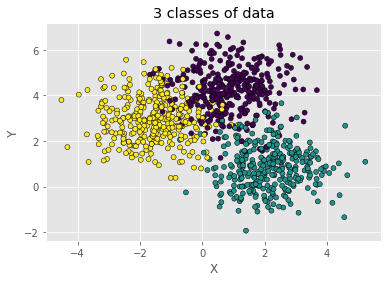

In [4]:
plt.scatter(X[:, 0], X[:, 1], marker='o', c=y, s=25, edgecolor='k')
plt.title("3 classes of data")
plt.xlabel("X")
plt.ylabel("Y")
plt.show()

Next we're going to split all our data into train and test sets then split the train set into model and validation.
We do so using sklearn's [`train_test_split`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) function.

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, test_size=0.2)
X_model, X_valid, y_model, y_valid = train_test_split(X_train, y_train, random_state=0, test_size=0.2)

print(f"All Data:        {len(X)} points")
print(f"Training data:   {len(X_train)} points")
print(f"Testing data:    {len(X_test)} points")
print(f"Modeling data:   {len(X_model)} points")
print(f"Validation data: {len(X_valid)} points")

All Data:        1000 points
Training data:   800 points
Testing data:    200 points
Modeling data:   640 points
Validation data: 160 points


Now we will load the models that we're going to use to fit this data. We will use sklearn's [$k$NN classifier](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html). 

In [0]:
from sklearn.neighbors import KNeighborsClassifier

In [0]:
k = 5

In [0]:
# Step 1 - Initialize model with parameters
knn = KNeighborsClassifier(n_neighbors=k)
# Step 2 - Fit the model data
knn.fit(X_model, y_model)
# Step 3 - Predict the validation data
validationPredictions = knn.predict(X_valid)

Now that we have a model trained, we'll need to evaluate it. We'll load some classification metrics:

1. [Classification Report](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html)
1. [Confusion matrix](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html)
1. [F1 score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html)

In [0]:
from sklearn.metrics import classification_report, confusion_matrix, f1_score

In [10]:
print(confusion_matrix(y_valid, validationPredictions))

[[50  5  3]
 [ 1 40  1]
 [ 5  3 52]]


In [11]:
print(classification_report(y_valid,validationPredictions))

              precision    recall  f1-score   support

           0       0.89      0.86      0.88        58
           1       0.83      0.95      0.89        42
           2       0.93      0.87      0.90        60

    accuracy                           0.89       160
   macro avg       0.88      0.89      0.89       160
weighted avg       0.89      0.89      0.89       160



In [12]:
f1_score(y_valid, validationPredictions, average="weighted")

0.8875226860254084

Let's use the weighted F-1 score as the metric to measure how good a model is and use the validation set to determine the best value for `k` neighbors.

In [0]:
def get_knn_training_scores(ks, model_features, model_labels):
    """Determine the f1-score of k values for kNN on a given data set
    Args:
        ks (int iterable): iterable of all the k values to apply
        model_features (iterable): the features from the model set to train on
        model_labels (iterable): the labels from the model set to train on
        
    Returns:
        dictionary: key is the k value and value is the weighted f1_score on the training set
    """
    values = {}
    bkscore = 0
    bscore = 0
    for k in ks:
      # Step 1 - Initialize model with parameters
      knn = KNeighborsClassifier(n_neighbors=k)
      # Step 2 - Fit the model data
      knn.fit(model_features, y_model)
      # Step 3 - Predict the validation data
      validationPredictions = knn.predict(model_features)
      score = f1_score(model_labels, validationPredictions, average="weighted")
      values[k]=score
      print("k = ", k, "score = ", score)
      if score > bscore:
        bscore = score
        bkscore = k
    print("best k training = ", bkscore)
    return values
      

In [14]:
ks = [1,2,3]
test_knn_train = get_knn_training_scores(ks, X_model, y_model)
assert list(test_knn_train.keys()) == ks
assert len(test_knn_train.keys()) == 3
assert np.array(list(test_knn_train.values())).all() <= 1
assert np.array(list(test_knn_train.values())).all() > 0

k =  1 score =  1.0
k =  2 score =  0.9424149278170167
k =  3 score =  0.9391139179386385
best k training =  1


In [0]:
def get_knn_validation_scores(ks, model_features, model_labels, validation_features, validation_labels):
    """Train a model on a dataset then return the F-1 score on another set
    Args:
        ks (int iterable): iterable of all the k values to apply
        model_features (iterable): the features from the model set to train on
        model_labels (iterable): the labels from the model set to train on
        validation_features (iterable): the features from the validation set to test on
        validation_labels (iterable): the labels from the validation set to test on
        
    Returns:
        dictionary: key is the k value and value is the weighted f1_score on the validation set
    """
    values = {}
    bkscore = 0
    bscore = 0
    for k in ks:
      # Step 1 - Initialize model with parameters
      knn = KNeighborsClassifier(n_neighbors=k)
      # Step 2 - Fit the model data
      knn.fit(model_features, model_labels)
      # Step 3 - Predict the validation data
      validationPredictions = knn.predict(validation_features)
      score = f1_score(validation_labels, validationPredictions, average="weighted")
      values[k]=score
      print("k = ", k, "score = ", score)
      if score > bscore:
        bscore = score
        bkscore = k
    print("best k validation = ", bkscore)    
    return values

In [16]:
ks = [1,2,3]
test_knn_valid = get_knn_validation_scores(ks, X_model, y_model, X_valid, y_valid)
assert list(test_knn_train.keys()) == ks
assert len(test_knn_train.keys()) == 3
assert np.array(list(test_knn_train.values())).all() <= 1
assert np.array(list(test_knn_train.values())).all() > 0
assert test_knn_valid != test_knn_train

k =  1 score =  0.8310148902821318
k =  2 score =  0.8366440224383715
k =  3 score =  0.8686369509043927
best k validation =  3


Now let's use these functions to determine the best value for $k$.

In [17]:
ksToTest = [1,3,5,7,10,20,50,100]
training_scores = get_knn_training_scores(ksToTest, X_model, y_model)
validation_scores = get_knn_validation_scores(ksToTest, X_model, y_model, X_valid, y_valid)

k =  1 score =  1.0
k =  3 score =  0.9391139179386385
k =  5 score =  0.935804639818995
k =  7 score =  0.9343018224659592
k =  10 score =  0.9328233138517558
k =  20 score =  0.9328070509913268
k =  50 score =  0.9296258909776576
k =  100 score =  0.9282034817351598
best k training =  1
k =  1 score =  0.8310148902821318
k =  3 score =  0.8686369509043927
k =  5 score =  0.8875226860254084
k =  7 score =  0.8871829813006282
k =  10 score =  0.8873793440358473
k =  20 score =  0.874428132525958
k =  50 score =  0.8868571031415069
k =  100 score =  0.8804385272541555
best k validation =  5


Here, we'll plot the training and validation scores that were returned from the functions. 

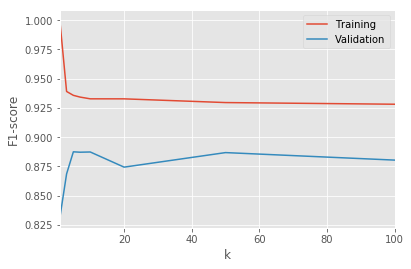

In [18]:
pd.Series(training_scores, name="Training").plot(kind="line")
pd.Series(validation_scores, name="Validation").plot(kind="line", label="Validation")
plt.legend()
plt.xlabel("k")
plt.ylabel("F1-score")
plt.show()

In [0]:
# Select the best value for k and set it to bestK
bestK = 5

In [0]:
clf = KNeighborsClassifier(bestK)
clf.fit(X_train, y_train)
testPredictions = clf.predict(X_test)

After selecting the best hyperparameter, we see how well it does on the test dataset as a sanity check. This is our final check after training the models to confirm that our validation was sufficient. 

In [21]:
print("Confusion Matrix: \n")
print(confusion_matrix(y_test, testPredictions))
print("\n\nClassification Report:\n")
print(classification_report(y_test, testPredictions))

Confusion Matrix: 

[[50  3  5]
 [ 3 67  1]
 [ 5  1 65]]


Classification Report:

              precision    recall  f1-score   support

           0       0.86      0.86      0.86        58
           1       0.94      0.94      0.94        71
           2       0.92      0.92      0.92        71

    accuracy                           0.91       200
   macro avg       0.91      0.91      0.91       200
weighted avg       0.91      0.91      0.91       200



In [0]:
assert f1_score(y_test, testPredictions, average="weighted") > 0.9

## Feedback

In [0]:
def feedback():
    """Provide feedback on the contents of this exercise
    
    Returns:
        string
    """
    print("Wish there was more explaination about why we split the training set \ninto model and validation. I thought that the test set was to check \nthe validity/accuracy of the model.")

In [24]:
feedback()

Wish there was more explaination about why we split the training set 
into model and validation. I thought that the test set was to check 
the validity/accuracy of the model.
